In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from alpaca_data_loader import load_dataframe, train_val_split, AlpacaDataset, DATA_DIR

plt.style.use("default")
print("Data folder ➜", DATA_DIR.resolve())

Data folder ➜ /Users/danie/repos/alpaca-segmentation/data


In [2]:
# Cell 1
raw_df   = load_dataframe("raw")
clips_df = load_dataframe("clips")
hums_df  = load_dataframe("hums")

raw_df.shape, clips_df.shape, hums_df.shape

((45, 21), (240, 24), (1549, 30))

In [3]:
# Cell 2
display(hums_df.head())
print("Unique animals :", hums_df.animal_id.unique())
print("Date range     :", hums_df.date.min(), "→", hums_df.date.max())
print("Mean hum dur   :", hums_df.duration_s.mean(), "s")
print("Quality counts :\n", hums_df.quality.value_counts().sort_index())

,uid,type,path,animal_id,date,extra_tag,duration_s,samplerate,channels,rms_db,...,fmax,raw_uid,clip_uid,clip_start_s,clip_end_s,hum_start_s,hum_end_s,hum_start_rel_clip_s,hum_end_rel_clip_s,quality
0,286,hum_segment,segmented_wav_onlyhums/387_20201207_cut.wav_11...,387,2020-12-07,None,0.382458,48000,1,-45.633250,...,4000,1,4,110.0,125.0,450.653259,451.035709,NaN,NaN,3
1,287,hum_segment,segmented_wav_onlyhums/387_20201207_cut.wav_11...,387,2020-12-07,None,0.382458,48000,1,-34.585644,...,4000,1,4,110.0,125.0,672.339337,672.721787,NaN,NaN,3
2,288,hum_segment,segmented_wav_onlyhums/387_20201207_cut.wav_11...,387,2020-12-07,None,0.223104,48000,1,-36.021596,...,4000,1,4,110.0,125.0,836.878593,837.101688,NaN,NaN,3
3,289,hum_segment,segmented_wav_onlyhums/387_20201207_cut.wav_11...,387,2020-12-07,None,0.116854,48000,1,-32.469983,...,4000,1,4,110.0,125.0,837.186679,837.303538,NaN,NaN,3
4,290,hum_segment,segmented_wav_onlyhums/387_20201207_cut.wav_15...,387,2020-12-07,None,0.116854,48000,1,-41.529107,...,4000,1,5,150.0,165.0,226.665332,226.782192,NaN,NaN,3


Unique animals : ['387' '388' '391' '400' '401' 'eli' 'emme' 'lou' 'mabel' 'mary' 'tif'
 'tina']
Date range     : 2020-12-07 → 2020-12-15
Mean hum dur   : 0.3318107112115343 s
Quality counts :
 quality
1    189
2    406
3    568
4    386
Name: count, dtype: int64


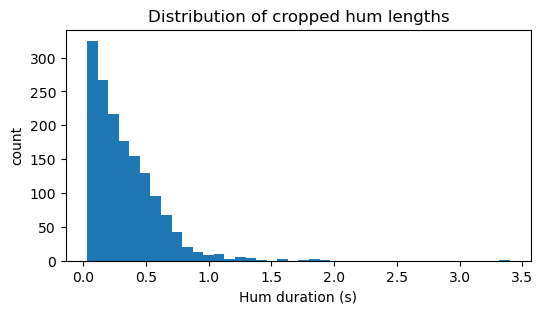

In [4]:
# Cell 3
plt.figure(figsize=(6,3))
plt.hist(hums_df.duration_s, bins=40)
plt.xlabel("Hum duration (s)")
plt.ylabel("count")
plt.title("Distribution of cropped hum lengths")
plt.show()

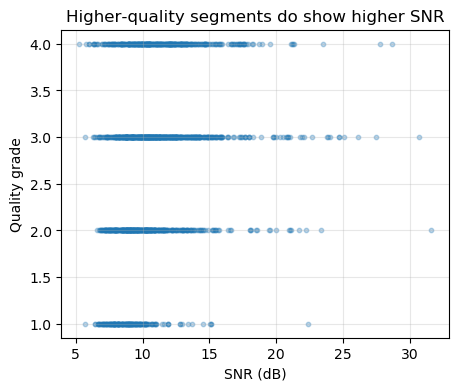

In [5]:
# Cell 4
plt.figure(figsize=(5,4))
plt.scatter(hums_df.snr_db, hums_df.quality, alpha=0.3, s=10)
plt.xlabel("SNR (dB)")
plt.ylabel("Quality grade")
plt.title("Higher‐quality segments do show higher SNR")
plt.grid(True, alpha=0.3)
plt.show()

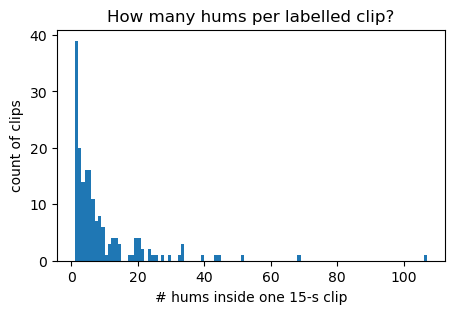

In [6]:
# Cell 5
hums_per_clip = hums_df.groupby("clip_uid").size()
plt.figure(figsize=(5,3))
plt.hist(hums_per_clip, bins=range(1, hums_per_clip.max()+2))
plt.xlabel("# hums inside one 15-s clip")
plt.ylabel("count of clips")
plt.title("How many hums per labelled clip?")
plt.show()

Picked UID 438 → 387_20201208_cut.wav_165_180.wav_576.704904764_576.949247546Q3.wav duration 0.24435416666666668 s


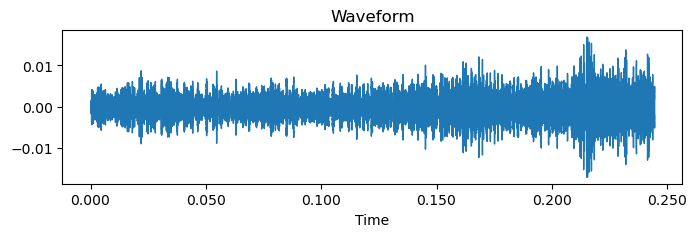

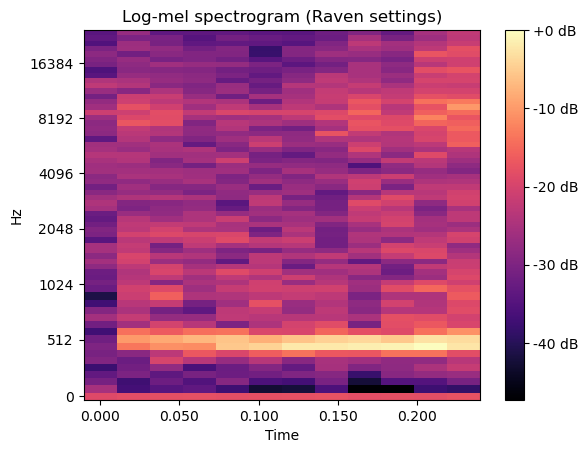

In [7]:
# Cell 7
from IPython.display import Audio, display
import librosa.display
import librosa
import random, os

row = hums_df.sample(1, random_state=0).iloc[0]
wav_path = DATA_DIR / row.path
y, sr = librosa.load(wav_path, sr=None)
print("Picked UID", row.uid, "→", os.path.basename(wav_path), "duration", row.duration_s, "s")

# waveform
plt.figure(figsize=(8,2))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.show()

# mel-spectrogram (recompute for visual clarity)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2002, hop_length=1001,
                                   n_mels=64, fmin=0, fmax=4000, power=2.0)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         sr=sr, hop_length=1001, x_axis="time", y_axis="mel")
plt.colorbar(format="%+0.0f dB")
plt.title("Log-mel spectrogram (Raven settings)")
plt.show()

display(Audio(y, rate=sr))

In [8]:
# Cell 8
train_idx, val_idx = train_val_split(hums_df, test_size=0.2)
print(f"Train {len(train_idx)}   Val {len(val_idx)}")
print("Animal IDs in train :", sorted(hums_df.iloc[train_idx].animal_id.unique()))
print("Animal IDs in val   :", sorted(hums_df.iloc[val_idx].animal_id.unique()))

Train 1133   Val 416
Animal IDs in train : ['388', '391', '400', '401', 'eli', 'emme', 'lou', 'mabel', 'tina']
Animal IDs in val   : ['387', 'mary', 'tif']


In [10]:
# Cell 9
import torch
from torch.utils.data import DataLoader

train_ds = AlpacaDataset(hums_df.iloc[train_idx])
dl = DataLoader(train_ds, batch_size=8, shuffle=True)

xb, tgt, meta = next(iter(dl))
print("Batch shapes:", xb.shape, {k:v.shape for k,v in tgt.items()})
assert torch.isfinite(xb).all()

Batch shapes: torch.Size([8, 3, 224, 224]) {'t_start_raw': torch.Size([8]), 't_end_raw': torch.Size([8]), 't_start_clip': torch.Size([8]), 't_end_clip': torch.Size([8]), 'quality': torch.Size([8]), 'loss_weight': torch.Size([8])}
